<a href="https://colab.research.google.com/github/haleelsada/MY-PROJECTS/blob/main/Gan_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this colab tells how a gan model works in simple terms and make a basic gan model with mnist digits dataset. in simple terms gans are models that can generate new similar sample data (image,text etc) based on data we feed in. 
models like instagram filters,changing b&w images to color,making images from drawings etc are based on generator model concept

the model is based on a basic binary classifier model(discriminator) and a generative model(generator) 
- we makes classifier model first and train it on mnist dataset to tells an image contain a number or not(ie an image is fake or real)
-then make an generator model same way we make classifier
-the input of generator will be a simple array of random numbers the output will be the image we wanted
-then the heart of this model 
-we make a new 'model' as generator first layer and the discriminator second layer
-in this new model:
-we lock the discriminator wheights which we trained earlier
-so now the first model produce a random image based on random array we made and out it in the second model and it tells is the image real or fake
-as we train more and more the first model's wheighs converge as if to make images of digits
-we monitor the output of the first layer and when we know it converged we stop it and take this first layer(generator) and deploy it for further usage

np:this is not completly correct but it gives a bigger picture of what we are doing and it is the basic of basic model in gan(like 'hello world' in languages

In [1]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot


11501568/11490434 [==============================] - 0s 0us/step
()


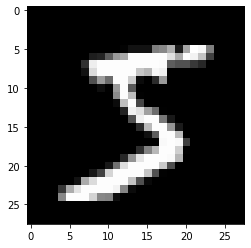

In [2]:
# load sample data
(trainX, trainy), (testX, testy) = load_data()
# this is train and test data
pyplot.imshow(trainX[0],cmap='gray')
print(trainy[0].shape)

In [3]:
# define the standalone discriminator model
# usual tensorflow binary classifier
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


In [4]:
# define the standalone generator model
# input is a random array and output out 28*28 2d matrix of image
# this 128 means we are making 128 different branches while training and getting sum of it
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model


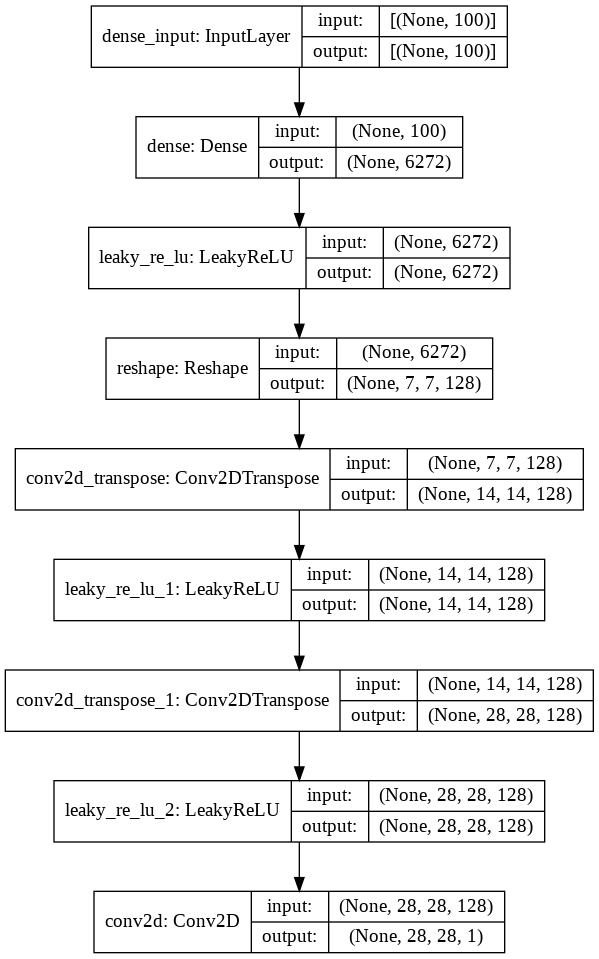

In [5]:
# to see model architecture properly 
from tensorflow.keras.utils import plot_model
model = Sequential()
# foundation for 7x7 image
n_nodes = 128 * 7 * 7
model.add(Dense(n_nodes, input_dim=100))
model.add(LeakyReLU(alpha=0.2))
model.add(Reshape((7, 7, 128)))
# upsample to 14x14
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
# upsample to 28x28
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

(60000, 28, 28, 1)


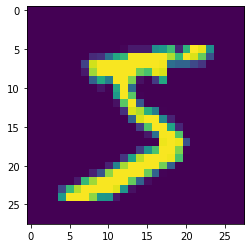

In [7]:
 # load and prepare mnist training images

def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
# tesing
t=load_real_samples()
print(t.shape)
# since it is in 3d we have to change it to 2d
t1=t[0].reshape((28,28))
pyplot.imshow(t1)

(1, 28, 28, 1)
[[1.]]


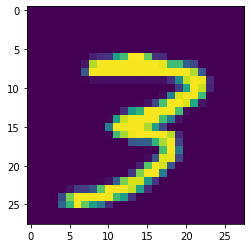

In [8]:
# select real samples
# gives real digits with label as 1
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
# tesing
m,n=generate_real_samples(t,1)
print(m.shape)
m1=m.reshape((28,28))
pyplot.imshow(m1)
print(n)

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# tesing
# gives 1 array of random 10 points
o=generate_latent_points(10,1)
print(o)

[[ 2.01866424  0.69120268  0.92585514 -1.36237127 -1.5997001  -1.04413583
   0.22976612  0.97420419  0.03631733 -0.03061332]]


In [10]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
# tesing



In [11]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [12]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=40, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

this train function is the brain of the gan model,here we intake fresh discriminator and gan (generator+discriminator) and iterare in epochs,

in each epoch we take whole data in batches then first train on discriminator alone with real data and generator produced fake data. and then train gan model which contain this trained discriminator(locked inside gan)which makes converge the generator inside the gan, then again we train discriminator and then gan and so on.

In [14]:

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
>19, 155/234, d=0.682, g=0.696
>19, 156/234, d=0.680, g=0.674
>19, 157/234, d=0.687, g=0.680
>19, 158/234, d=0.683, g=0.673
>19, 159/234, d=0.684, g=0.686
>19, 160/234, d=0.688, g=0.699
>19, 161/234, d=0.685, g=0.735
>19, 162/234, d=0.695, g=0.745
>19, 163/234, d=0.689, g=0.724
>19, 164/234, d=0.686, g=0.716
>19, 165/234, d=0.686, g=0.700
>19, 166/234, d=0.685, g=0.684
>19, 167/234, d=0.694, g=0.676
>19, 168/234, d=0.678, g=0.680
>19, 169/234, d=0.690, g=0.704
>19, 170/234, d=0.683, g=0.710
>19, 171/234, d=0.692, g=0.740
>19, 172/234, d=0.689, g=0.736
>19, 173/234, d=0.692, g=0.747
>19, 174/234, d=0.695, g=0.741
>19, 175/234, d=0.689, g=0.696
>19, 176/234, d=0.683, g=0.667
>19, 177/234, d=0.682, g=0.657
>19, 178/234, d=0.690, g=0.660
>19, 179/234, d=0.691, g=0.685
>19, 180/234, d=0.681, g=0.700
>19, 181/234, d=0.674, g=0.745
>19, 182/234, d=0.677, g=0.769
>19, 183/234, d=0.688, g=0.773
>19, 184/234, d=0.684, g=0.720
>19, 185/234, d=0.6

(28, 28)


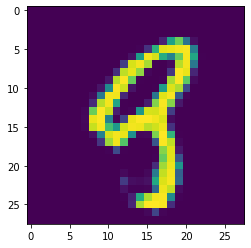

In [15]:
#the model is saved automatically after each epochs so we can retrieve it from files
#check gan's performence
from tensorflow.keras.models import load_model
model=load_model('/content/generator_model_040.h5')
t=model.predict(generate_latent_points(100,1))
t2=t.reshape((28,28))
pyplot.imshow(t2)
print(t2.shape)



In [16]:
# for testing we can put this points in our old disciminator to see the performense

d_model.predict(t)

array([[0.49252298]], dtype=float32)

(1, 28, 28, 1)
[[1.]]
[[0.5136323]]


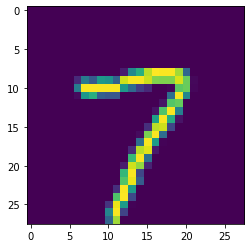

In [91]:
m,n=generate_real_samples(dataset,1)
print(m.shape)
m1=m.reshape((28,28))
pyplot.imshow(m1)
print(n)
print(d_model.predict(m))

In [20]:
from numpy.random import rand
from numpy.random import randint
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

[[0.18352474]]


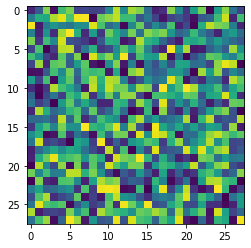

In [92]:

l,p=generate_fake_samples(1)
print(d_model.predict(l))
pyplot.imshow(l.reshape((28,28)))

thats it, note that discriminator is showing around 0.5 value for this generated and real images and near to 0 for fake images

------------------

from this point onwards is some failed experiment of mine

In [45]:
# discriminator model 2
from tensorflow.keras.utils import plot_model
model3 = Sequential()
model3.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
model3.add(LeakyReLU(alpha=0.2))
model3.add(Dropout(0.4))
model3.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
model3.add(LeakyReLU(alpha=0.2))
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


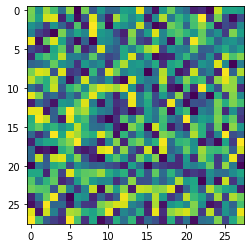

In [46]:

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
g,f=generate_fake_samples(1)

pyplot.imshow(g.reshape((28,28)))

In [47]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [48]:
train_discriminator(model3,dataset)

>1 real=46% fake=9%
>2 real=60% fake=24%
>3 real=59% fake=41%
>4 real=55% fake=64%
>5 real=59% fake=77%
>6 real=59% fake=84%
>7 real=60% fake=95%
>8 real=59% fake=99%
>9 real=55% fake=99%
>10 real=56% fake=100%
>11 real=55% fake=100%
>12 real=60% fake=100%
>13 real=55% fake=100%
>14 real=70% fake=100%
>15 real=65% fake=100%
>16 real=68% fake=100%
>17 real=60% fake=100%
>18 real=66% fake=100%
>19 real=70% fake=100%
>20 real=76% fake=100%
>21 real=66% fake=100%
>22 real=83% fake=100%
>23 real=79% fake=100%
>24 real=74% fake=100%
>25 real=83% fake=100%
>26 real=88% fake=100%
>27 real=84% fake=100%
>28 real=87% fake=100%
>29 real=88% fake=100%
>30 real=97% fake=100%
>31 real=94% fake=100%
>32 real=98% fake=100%
>33 real=97% fake=100%
>34 real=94% fake=100%
>35 real=95% fake=100%
>36 real=100% fake=100%
>37 real=99% fake=100%
>38 real=99% fake=100%
>39 real=98% fake=100%
>40 real=99% fake=100%
>41 real=99% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake=100%
>45

In [49]:
# g= random generated picture m=picture from dataset
print(model3.predict(g),model3.predict(m))

[[0.0013386]] [[0.99620265]]


In [50]:
model4 = Sequential()
# foundation for 7x7 image
n_nodes = 128 * 7 * 7
model4.add(Dense(n_nodes, input_dim=100))
model4.add(LeakyReLU(alpha=0.2))
model4.add(Reshape((7, 7, 128)))
# upsample to 14x14
model4.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
model4.add(LeakyReLU(alpha=0.2))
# upsample to 28x28
model4.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
model4.add(LeakyReLU(alpha=0.2))
model4.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))


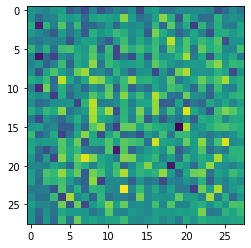

In [58]:
t=model4.predict(generate_latent_points(100,1))
pyplot.imshow(t.reshape((28,28)))

In [57]:
model4.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 28, 28, 128)     

In [53]:
# make weights in the discriminator not trainable
d1_model=model3
g1_model=model4
d1_model.trainable = False
# connect them
modelf = Sequential()
# add generator
modelf.add(g1_model)
# add the discriminator
modelf.add(d1_model)
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
modelf.compile(loss='binary_crossentropy', optimizer=opt)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [66]:
def train2(gan_model, dataset, latent_dim, n_epochs=40, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
#			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
#			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
#			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
#			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d,  g=%.3f' % (i+1, j+1, bat_per_epo, g_loss))
		# evaluate the model performance, sometimes
	

In [67]:
train2(modelf,dataset,100)

Streaming output truncated to the last 5000 lines.
>19, 149/234,  g=0.099
>19, 150/234,  g=0.099
>19, 151/234,  g=0.098
>19, 152/234,  g=0.100
>19, 153/234,  g=0.099
>19, 154/234,  g=0.099
>19, 155/234,  g=0.099
>19, 156/234,  g=0.100
>19, 157/234,  g=0.100
>19, 158/234,  g=0.100
>19, 159/234,  g=0.100
>19, 160/234,  g=0.100
>19, 161/234,  g=0.099
>19, 162/234,  g=0.098
>19, 163/234,  g=0.099
>19, 164/234,  g=0.100
>19, 165/234,  g=0.099
>19, 166/234,  g=0.100
>19, 167/234,  g=0.099
>19, 168/234,  g=0.099
>19, 169/234,  g=0.098
>19, 170/234,  g=0.098
>19, 171/234,  g=0.099
>19, 172/234,  g=0.100
>19, 173/234,  g=0.100
>19, 174/234,  g=0.100
>19, 175/234,  g=0.099
>19, 176/234,  g=0.099
>19, 177/234,  g=0.098
>19, 178/234,  g=0.100
>19, 179/234,  g=0.100
>19, 180/234,  g=0.099
>19, 181/234,  g=0.099
>19, 182/234,  g=0.100
>19, 183/234,  g=0.099
>19, 184/234,  g=0.100
>19, 185/234,  g=0.099
>19, 186/234,  g=0.099
>19, 187/234,  g=0.098
>19, 188/234,  g=0.100
>19, 189/234,  g=0.100
>19, 1

[[0.9925995]]


TypeError: ignored

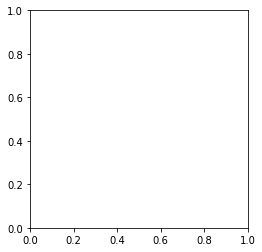

In [90]:
t=g1_model.predict(generate_latent_points(100,1))
t2=t.reshape((28,28))
#t4,_=generate_fake_samples(1)
t3,_=generate_real_samples(dataset,1)

print(model3.predict(t3))
#pyplot.imshow(t2)

pyplot.imshow(t3.reshape((14,14,2,2)))